In [1]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [2]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [3]:
SD = 0.05 * (0.8 ** 4) # -4 ... 10 
print('SD:', SD)

SD: 0.020480000000000005


In [4]:
DATA = '../models/qp/data'
SYMBOLS = [
    'ABMD', 'ABNB', 'ANET', 'ATVI', 'AXON', 'AYX', 'BILI', 'BYND', 'COUR',
    'CPNG', 'DDOG', 'DOCU', 'EDIT', 'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 
    'INTG', 'ISRG', 'JD', 'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MTCH', 
    'NVCR', 'OKTA', 'PANW', 'PINS', 'PTON', 'QDEL', 'RDFN', 'RGEN', 
    'ROKU', 'SE', 'SHOP', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 
    'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

50

In [5]:
N_YEARS = 50
N_CUTS = 10
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = datetime.now().date()
START = '1978-07-26' #str(TODAY - timedelta(N_DAYS))
START, TODAY

('1978-07-26', datetime.date(2021, 7, 27))

In [6]:
batcher = Batcher(SYMBOLS, INDICES)
batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch = batch[-1:]
batch

['DDOG',
 'DOCU',
 'EDIT',
 'ETSY',
 'FSLY',
 'FUV',
 'GH',
 'GMED',
 'INTG',
 'ISRG',
 '^IXIC']

In [7]:
stock_loader = Loader(batch, START, verbose=True)
data = stock_loader.download()

[*********************100%***********************]  11 of 11 completed
Generating derived columns...
   ...DDOG
   ...DOCU
   ...EDIT
   ...ETSY
   ...FSLY
   ...FUV
   ...GH
   ...GMED
   ...INTG
   ...ISRG
   ...^IXIC


In [8]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [9]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [10]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(f'Unexpected error getting {stock} data. '
              'Initialized as None.')

In [11]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [12]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best.json', 'w') as f:
        json.dump(best_param_set, f)

In [13]:
if TODAY.weekday() == 0:
    !say update standard deviation




----------------------------------------------------------------------
                                 DDOG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.4257623726709885
Refitting current best...
Current best ma returns: 2.3141646885024523
Fraction Invested: 0.9928143424426107
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 2.314305607939647
Invested: 0.9928143424426107
New best: 2.3188782095923854
Invested: 0.9928143424426107
New best: 2.3202840388409975
Invested: 0.9928143424426107
New best: 2.3205138268051715
Invested: 0.9928143424426107
New best: 2.3209086302712443
Invested: 0.9928143424426107
New best: 2.3209153302705605
Invested: 0.9928143424426107
Round: 25


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.4257623726709885
Refitting current best...
Current

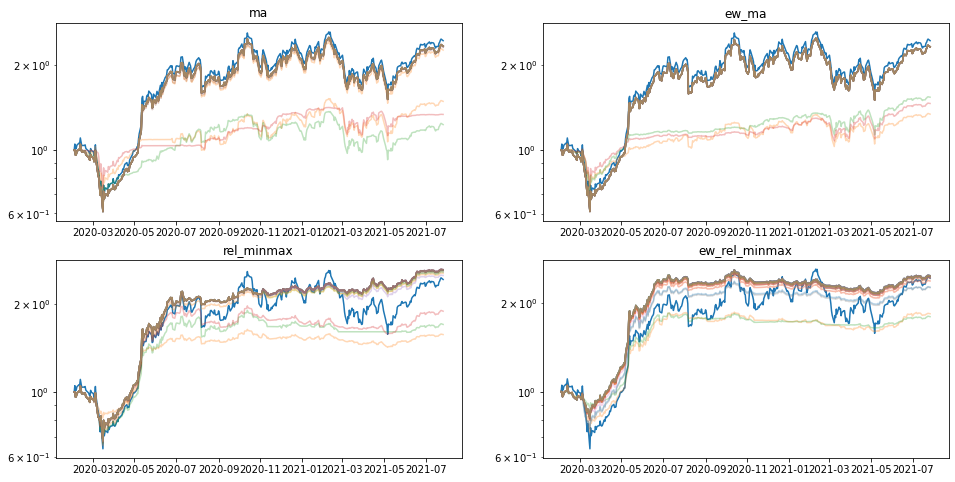

Saving DDOG params...



----------------------------------------------------------------------
                                 DOCU
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.437849293942324
Refitting current best...
Current best ma returns: 8.394643889339168
Fraction Invested: 0.994987645892004
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 8.395271139724699
Invested: 0.9955184260105077
Round: 25


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.437849293942324
Refitting current best...
Current best ew_ma returns: 10.56906325315808
Fraction Invested: 0.9977076279797129
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 10.56925462476177
Invested: 0.9977076279797129
New best: 10.569580607441642
Invested: 0.9977076279797129



Beginning re

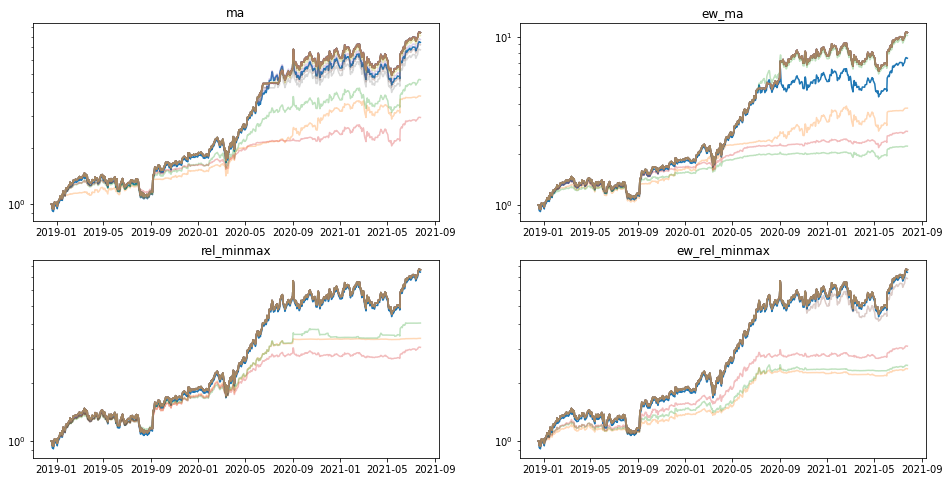

Saving DOCU params...



----------------------------------------------------------------------
                                 EDIT
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.8163171150457202
Refitting current best...
Current best ma returns: 3.701916609553451
Fraction Invested: 0.503396740241289
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 3.7034240743686486
Invested: 0.503396740241289
Round: 25


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 1.8163171150457202
Refitting current best...
Current best ew_ma returns: 4.233338386974365
Fraction Invested: 0.005331197093211493
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 4.237461965822295
Invested: 0.005331197093211493
New best: 4.302928273498982
Invested: 0.005331197093211493
New best

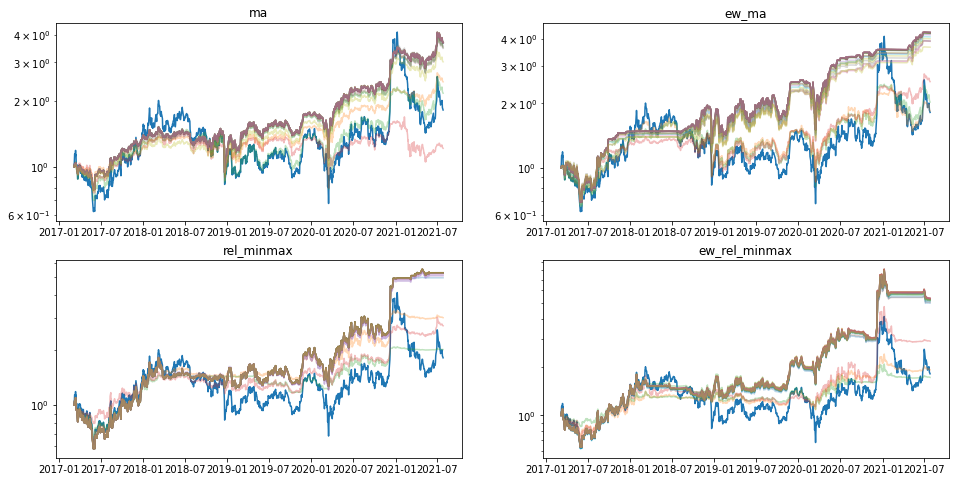

Saving EDIT params...



----------------------------------------------------------------------
                                 ETSY
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 20.855263225208738
Refitting current best...
Current best ma returns: 21.645051763671475
Fraction Invested: 0.9999847283586695
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 21.645618023864046
Invested: 0.9999847283586695
New best: 21.648304349713868
Invested: 0.9999847283586695
New best: 21.648394540575246
Invested: 0.9999847283586695
Round: 25


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 20.855263225208738
Refitting current best...
Current best ew_ma returns: 26.79164657175378
Fraction Invested: 0.9974024348203466
Beginning random search...
Round: 3
Beginning adjusted search...
New best:

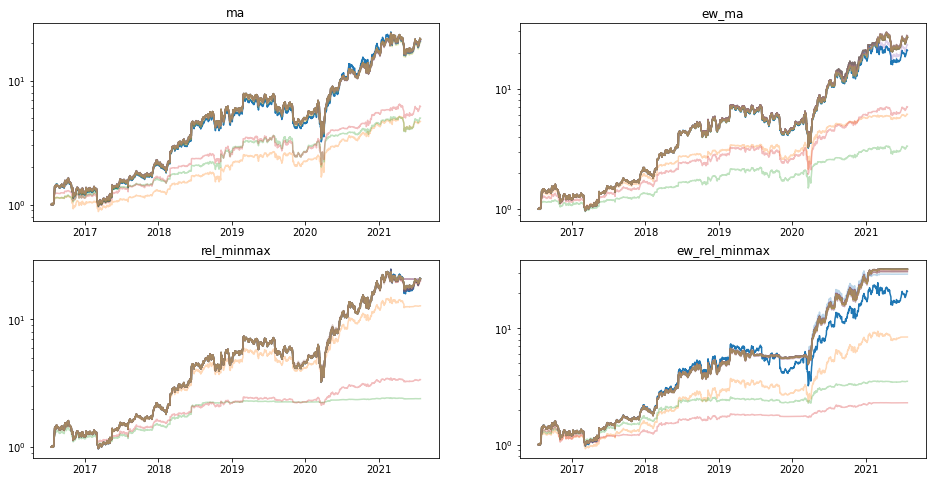

Saving ETSY params...



----------------------------------------------------------------------
                                 FSLY
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 2.446053951098326
Refitting current best...
Current best ma returns: 2.367864670334515
Fraction Invested: 0.9934441825252865
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 2.3679738926087985
Invested: 0.9934441825252865
New best: 2.36809709036663
Invested: 0.9934441825252865
New best: 2.368123862703066
Invested: 0.9934441825252865
New best: 2.3681375461090948
Invested: 0.9934048586252737
New best: 2.3681377727595625
Invested: 0.9934048586252737
New best: 2.368145932646282
Invested: 0.9934048586252737
Round: 25


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 2.446053951098326
Refitting current

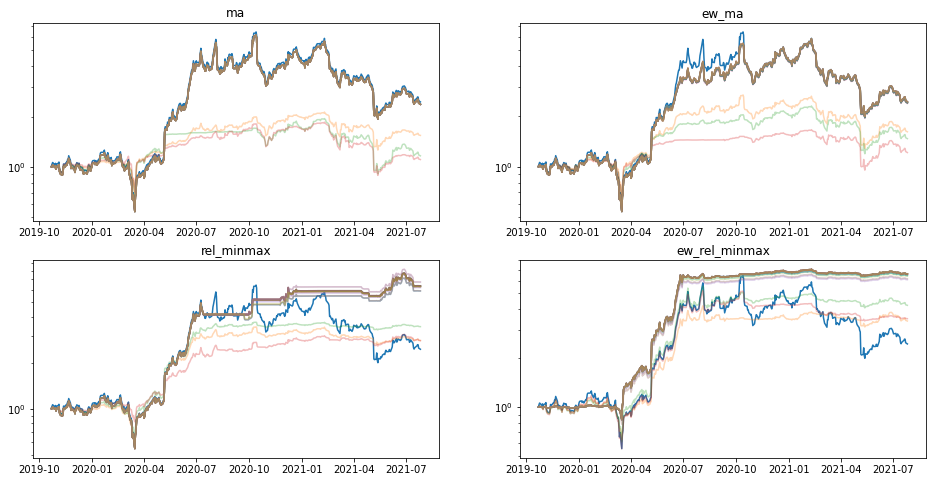

Saving FSLY params...



----------------------------------------------------------------------
                                 FUV
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.3977271557346875
Refitting current best...
Current best ma returns: 3.672222787363853
Fraction Invested: 0.9956009173460281
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 3.672222919851441
Invested: 0.9956009173460281
New best: 3.6734757060246457
Invested: 0.9956009173460281
New best: 3.6735131270457786
Invested: 0.9956009173460281



Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 3.3977271557346875
Refitting current best...
Current best ew_ma returns: 4.131391906433713
Fraction Invested: 0.9619243914879166
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 4.131397222

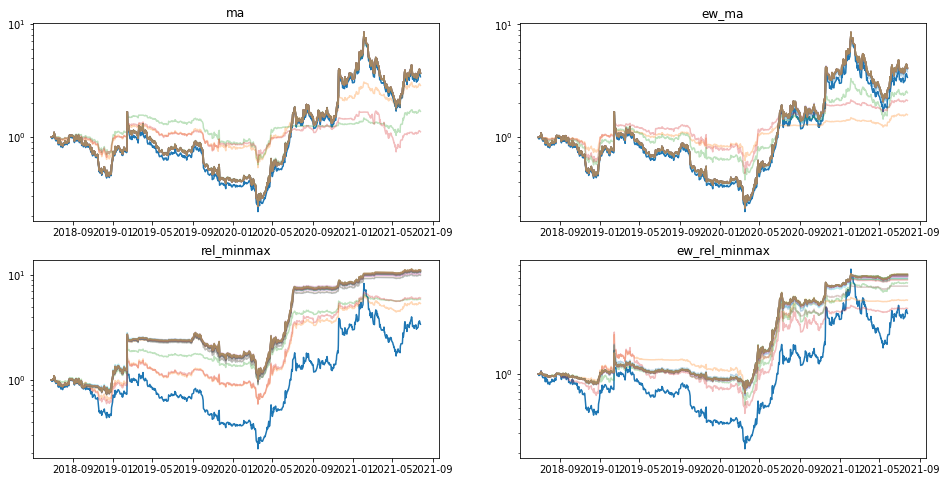

Saving FUV params...



----------------------------------------------------------------------
                                 GH
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 1.7059990610872127
Refitting current best...
Current best ma returns: 2.6335073759646126
Fraction Invested: 0.9999165405332722
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 2.636564115255473
Invested: 0.9999165405332722
New best: 2.6797968145618216
Invested: 0.9999165405332722
New best: 2.680591871116989
Invested: 0.9999165405332722
New best: 2.68271882955013
Invested: 0.9999165405332722
New best: 2.7135962186498777
Invested: 0.9999165405332722
New best: 2.7137468677987115
Invested: 0.9999165405332722
New best: 2.7178738502076216
Invested: 0.9999165405332722
New best: 2.7192088001187127
Invested: 0.9999165405332722
New best: 2.7215633729242272


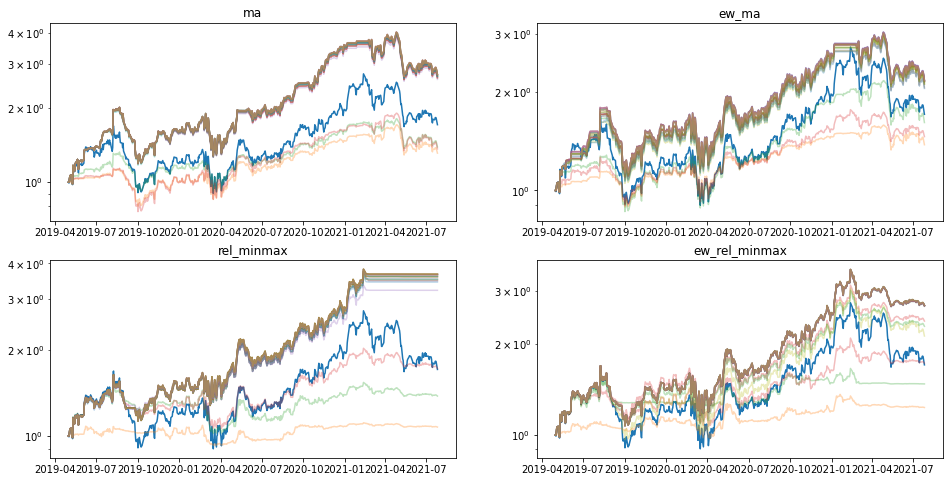

Saving GH params...



----------------------------------------------------------------------
                                 GMED
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 3.364854128078464
Refitting current best...
Current best ma returns: 3.2555542621761
Fraction Invested: 0.2590449351902878
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 3.2555549172033906
Invested: 0.2590449351902878
New best: 3.2555707873228803
Invested: 0.2590449351902878
New best: 3.2556278301302912
Invested: 0.2590449351902878
New best: 3.255677710873851
Invested: 0.2590449351902878
New best: 3.3143099176707405
Invested: 0.2590449351902878
New best: 3.3144182482885505
Invested: 0.2590449351902878
New best: 3.314418766027982
Invested: 0.2590449351902878
Round: 25


Beginning ew_ma method...
--------------------------------------------------

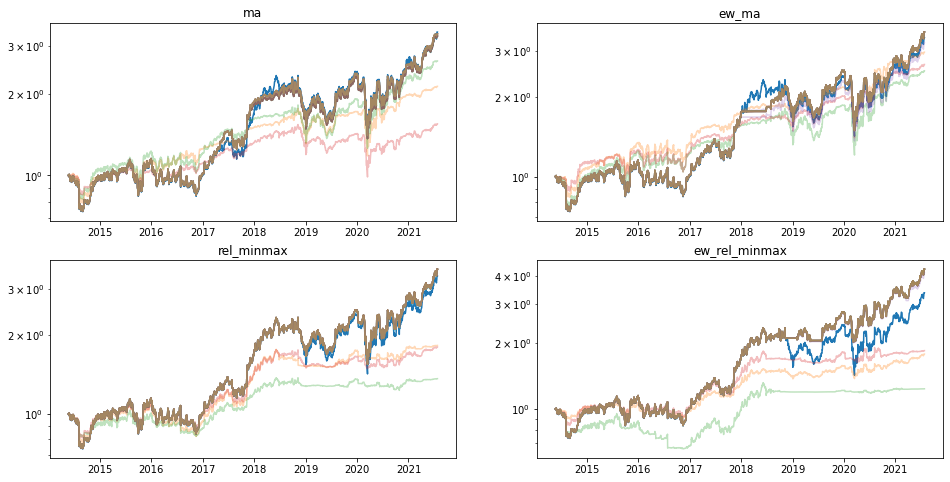

Saving GMED params...



----------------------------------------------------------------------
                                 INTG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 11.571428019659885
Refitting current best...
Current best ma returns: 74.00973070307253
Fraction Invested: 0.12041138710839189
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 76.50639171774398
Invested: 0.12041138710839189
New best: 90.05037976082437
Invested: 0.12041138710839189
New best: 93.71154543106039
Invested: 0.12041138710839189
New best: 98.54131491613269
Invested: 0.08650566025449706
New best: 98.5660617612821
Invested: 0.08650566025449706
New best: 98.97445178794722
Invested: 0.08650566025449706
New best: 202.97772627336028
Invested: 0.08650566025449706
New best: 222.04561178610544
Invested: 0.08650566025449706
New best: 320.0208188

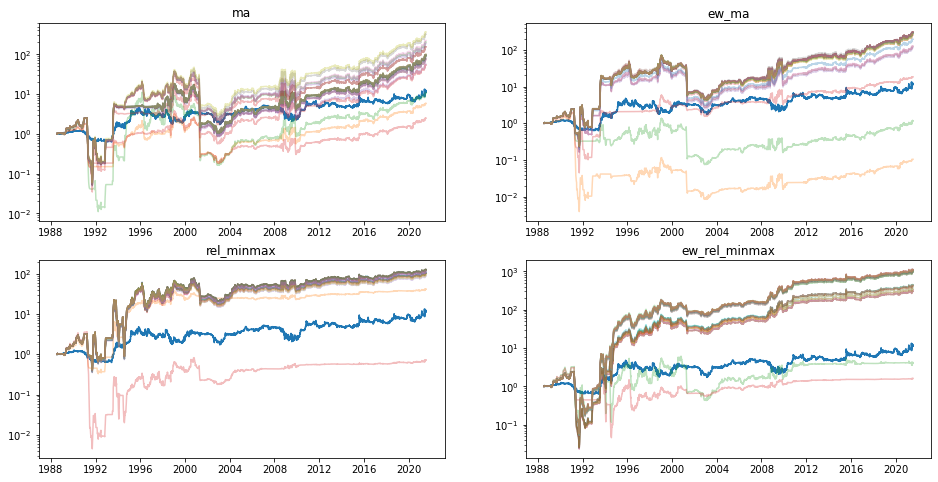

Saving INTG params...



----------------------------------------------------------------------
                                 ISRG
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 107.94413365079856
Refitting current best...
Current best ma returns: 140.3802979719014
Fraction Invested: 0.9979992560129611
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 140.38287141811688
Invested: 0.998020764130744
New best: 140.38297285345675
Invested: 0.998020764130744
Round: 25


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 107.94413365079856
Refitting current best...
Current best ew_ma returns: 174.79737459047695
Fraction Invested: 0.9918126402791181
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 174.79795587932165
Invested: 0.9918126402791181
New best: 1

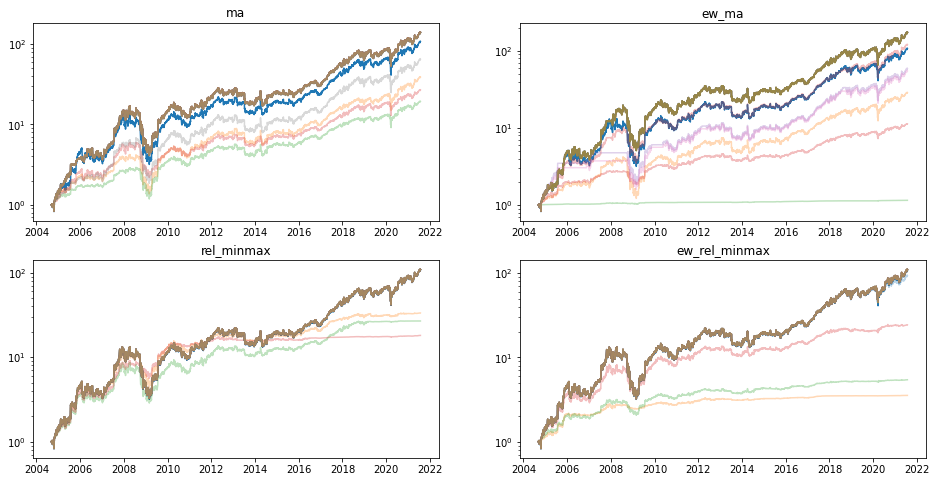

Saving ISRG params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 35.96875846195255
Refitting current best...
Current best ma returns: 40.91226132127988
Fraction Invested: 0.9940107880613743
Beginning random search...
Round: 3
Beginning adjusted search...
New best: 40.91296954598735
Invested: 0.9940107880613743
New best: 40.912976249593314
Invested: 0.9940107880613743
New best: 40.943063368160594
Invested: 0.9946862667634415
New best: 40.96797434102533
Invested: 0.9946862667634415
New best: 40.96798360346467
Invested: 0.9946862667634415
Round: 25


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 35.96875846195255
Refitting current best...
Current best ew_ma returns: 44.715823496679604


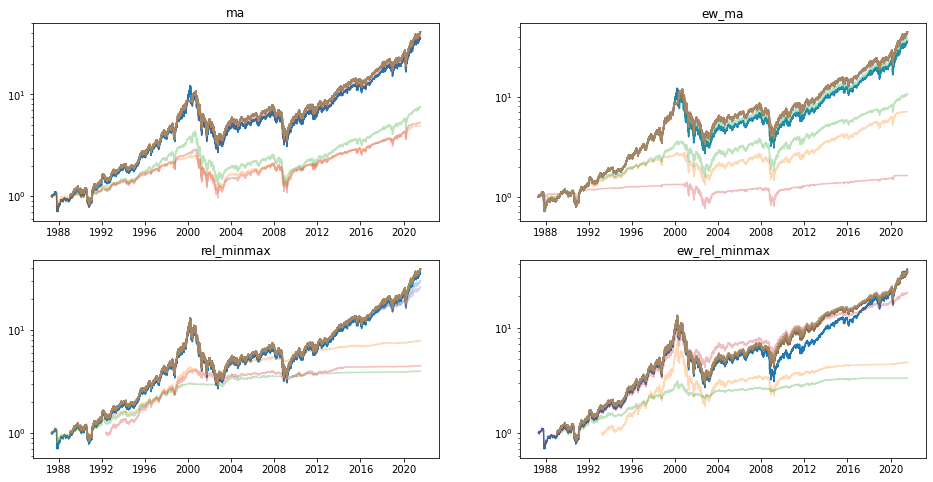

Saving ^IXIC params...


In [14]:
N_RAND = 3
N_ADJ = 25

for stock in batch:
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    best_params, best_returns = read_best_params(stock)
    stock_data = get_stock_data(stock, data)
    if stock == 'INTG':
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
    qp = QPercent(stock_data, 
                  N_CUTS, 
                  best_param_set=best_params, 
                  best_returns=best_returns, 
                  sd=SD)
    qp.run_sims(N_RAND, N_ADJ)
    best = get_best_param_set(qp)
    save_best_param_set(best, stock)

In [15]:
def get_summary(stocks):
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {100 * best_pct:.2f}% in')
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue

In [16]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
get_summary(batch)


DDOG:
  Best Return: 2.6223409402147073 (rel_minmax)
  27.65% in

DOCU:
  Best Return: 10.569580607441642 (ew_ma)
  99.77% in

EDIT:
  Best Return: 5.351862356271822 (ew_rel_minmax)
  0.02% in

ETSY:
  Best Return: 32.378473374498014 (ew_rel_minmax)
  0.26% in

FSLY:
  Best Return: 6.747386593167204 (rel_minmax)
  0.02% in

FUV:
  Best Return: 11.154441647452895 (rel_minmax)
  9.36% in

GH:
  Best Return: 3.6694197423952044 (rel_minmax)
  0.17% in

GMED:
  Best Return: 4.303671877190636 (ew_rel_minmax)
  99.38% in

INTG:
  Best Return: 1111.2303363139558 (ew_rel_minmax)
  25.74% in

ISRG:
  Best Return: 174.8100676823793 (ew_ma)
  99.18% in

^IXIC:
  Best Return: 44.72145559504905 (ew_ma)
  99.47% in


In [17]:
!say qp is dunzo

IXIC: Nasdaq